# Libraries &#x1F4DA;

Let's import the python libraries we need to do our analysis.

To make things more convenient, we can shorten the name of the python library we're importing by defining them with `as`.

In [1]:
# Library for handling multi-dimensional data (lat, lon, time, etc.)
import xarray as xr
# Library for general handling of arrays
import numpy as np
# Library for handling cartographic projections
import cartopy.crs as ccrs

# Section 1: Xarray introduction (open netcdf files, subsetting, simple plotting)

The Standardized Precipitation Index (SPI) is a measure of how dry a region is based on the meteorological data of precipitation. Let's learn how to open a netCDF file containing precipitation data so that, at one point, we can calculate SPI. We have precipitation data from the [Norwegian Earth System Model](https://gmd.copernicus.org/articles/special_issue20.html) developed by the Norwegian Climate Center. The data is produced from the second version of the model with low-resolution for atmosphere-land and medium-resolution for ocean-sea ice, this model version is called [NorESM2-LM](https://gmd.copernicus.org/articles/13/6165/2020/gmd-13-6165-2020.html). This version of the model is part of the suite of climate models used to see the effect of rapid reduction in anthropogenic aerosol emissions in the [Regional Aerosol Model Intercomparison Project](https://gmd.copernicus.org/articles/16/4451/2023/gmd-16-4451-2023.html) (RAMIP).

The data is stored in this directory: `/home/persad_research/SIMULATION_DATA/DATA/RAMIP/NorESM2-LM/historical/r1i1p1f1/atm/day/pr/` and the netCDF file name is: `pr_day_NorESM2-LM_historical_r1i1p1f1_gn_all.nc`

To open a netCDF using xarray, we can use the `open_dataset()` function from the xarray library which we have defined as `xr` in this notebook.

In [2]:
data_noresm2 = xr.open_dataset('/home/persad_research/SIMULATION_DATA/DATA/RAMIP/NorESM2-LM/historical/r1i1p1f1/atm/day/pr/pr_day_NorESM2-LM_historical_r1i1p1f1_gn_all.nc')
data_noresm2

<xarray.Dataset> Size: 864MB
Dimensions:    (time: 14600, bnds: 2, lat: 96, lon: 144)
Coordinates:
  * time       (time) object 117kB 1960-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat        (lat) float64 768B -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon        (lon) float64 1kB 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 234kB ...
    lat_bnds   (time, lat, bnds) float64 22MB ...
    lon_bnds   (time, lon, bnds) float64 34MB ...
    pr         (time, lat, lon) float32 807MB ...
Attributes: (12/49)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1600-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     430335.0
    ...                        ...
    title:                     NorESM2-LM output prepared for CMIP6
    variable_id:               pr
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/57c46dc8-11d7-413c-9be6-02eccd000d12

We have opened the netCDF file and the data is read in as an xarray Dataset as shown in the upper left side corner. We gave the xarray Dataset a name and it is called `data_noresm2`. By typing the name in the code block afterwards, we can show how the data looks like. An xarray Dataset contains multiple data variables (time_bnds, lat_bnds, lon_bnds, and pr). In this case, we just need the precipitation data which is named `pr` following the [naming convention](https://clipc-services.ceda.ac.uk/dreq/mipVars.html) from the sixth [Coupled Model Intercomparison Project (CMIP6)](https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained/).

Let's take only precipitation data from the xarray Dataset and create an xarray DataArray called `pr_noresm2`. An xarray DataArray only has one variable unlike an xarray Dataset.

In [3]:
pr_noresm2 = data_noresm2['pr']
pr_noresm2

<xarray.DataArray 'pr' (time: 14600, lat: 96, lon: 144)> Size: 807MB
[201830400 values with dtype=float32]
Coordinates:
  * time     (time) object 117kB 1960-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 768B -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          kg m-2 s-1
    original_name:  PRECT
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-08-15T17:17:16Z altered by CMOR: Converted type from...

We focus on the dimensions (time, lat, lon) after selecting the variable of interest so that we are not paying attention to dimensions that are not relevant to the variable we are focusing on. Typically, we also immediately indicate the variable of focus while reading the file. Hence we could have done `pr_noresm2 = xr.open_dataset('/home/persad_research/SIMULATION_DATA/DATA/RAMIP/NorESM2-LM/historical/r1i1p1f1/atm/day/pr/pr_day_NorESM2-LM_historical_r1i1p1f1_gn_all.nc')['pr']` and gotten the same result.

Let's take only a subset of the data by selecting only the region within the East Asian latitude and longitude boundaries defined in RAMIP. We define the latitude and longitude boundaries in the following code block.

In [4]:
lat_bot_eas = 20
lat_top_eas = 53
lon_west_eas = 95
lon_east_eas = 133

There are multiple ways to subset an xarray DataArray, we can use the functions: (1) `.sel()` if we want to indicate the coordinate *value* when taking the subset, (2) `.isel()` if we want to indicate the *index* when taking the subset, or (3) alternatively do a [NumPy](https://numpy.org/doc/2.1/user/basics.indexing.html)-like selection.

Since we have the latitude and longitude *values*, we can use `.sel()` to subset the data. Here we provide *slices* of latitude and longitude which indicates the boundaries of the data we are taking.

In [5]:
pr_noresm2_eas = pr_noresm2.sel(lat=slice(lat_bot_eas, lat_top_eas), lon=slice(lon_west_eas, lon_east_eas))
pr_noresm2_eas

<xarray.DataArray 'pr' (time: 14600, lat: 17, lon: 16)> Size: 16MB
[3971200 values with dtype=float32]
Coordinates:
  * time     (time) object 117kB 1960-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 136B 21.79 23.68 25.58 27.47 ... 48.32 50.21 52.11
  * lon      (lon) float64 128B 95.0 97.5 100.0 102.5 ... 127.5 130.0 132.5
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    comment:        includes both liquid and solid phases
    units:          kg m-2 s-1
    original_name:  PRECT
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-08-15T17:17:16Z altered by CMOR: Converted type from...

Let's try plotting a map of global precipitation and East Asian precipitation! But remember, since a map is a 2D representation of the data, we can only map data that has exclusively the lat and lon dimensions. So, here we'll select only data from the *first* day. Since we know the *index* of the time dimension, we can use `.isel()`. Note that xarray indexing uses the convention that the *first* data is indexed as *zero*!

In [6]:
pr_noresm2_first_day = pr_noresm2.isel(time=0)
pr_noresm2_eas_first_day = pr_noresm2_eas.isel(time=0)

Here's what the first day of global precipitation looks like.

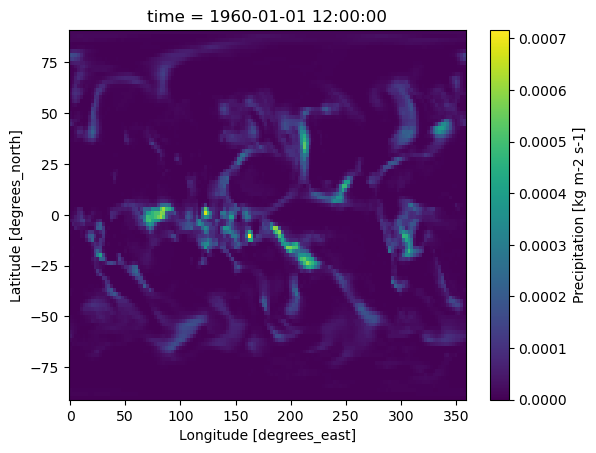

In [7]:
pr_noresm2_first_day.plot()

You can see that we have this printed out: `<matplotlib.collections.QuadMesh at 0x7ef856b554c0>`, to indicate that we don't want to see that we can add a semicolon at the end of `.plot()` for the next map we'll make. Here's what the first day of East Asian precipitation looks like.

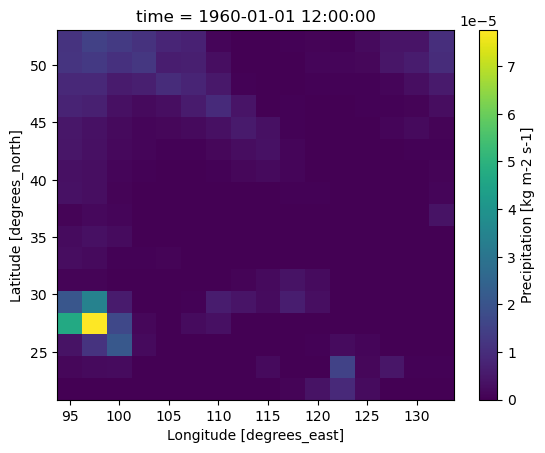

In [8]:
pr_noresm2_eas_first_day.plot();

We can also make a timeseries of daily precipitation for only one lat/lon coordinate in East Asia. Let's select the first lat/lon coordinate in East Asia. But before that let's check what lat and lon values that would be associated with.

In [9]:
pr_noresm2_eas.lat

<xarray.DataArray 'lat' (lat: 17)> Size: 136B
array([21.789474, 23.684211, 25.578947, 27.473684, 29.368421, 31.263158,
       33.157895, 35.052632, 36.947368, 38.842105, 40.736842, 42.631579,
       44.526316, 46.421053, 48.315789, 50.210526, 52.105263])
Coordinates:
  * lat      (lat) float64 136B 21.79 23.68 25.58 27.47 ... 48.32 50.21 52.11
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      Latitude
    standard_name:  latitude

In [10]:
pr_noresm2_eas.lon

<xarray.DataArray 'lon' (lon: 16)> Size: 128B
array([ 95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. , 112.5, 115. , 117.5,
       120. , 122.5, 125. , 127.5, 130. , 132.5])
Coordinates:
  * lon      (lon) float64 128B 95.0 97.5 100.0 102.5 ... 127.5 130.0 132.5
Attributes:
    bounds:         lon_bnds
    units:          degrees_east
    axis:           X
    long_name:      Longitude
    standard_name:  longitude

The first latitude in our model data that is within the East Asian boundary we provided is 21.79N while the first longitude is 95E. Note that we have displayed *xarray DataArrays* of the latitude and longitudes. If you only want a *Numpy array* of the latitude and longitudes, you need to do `.values` at the end. The following is an example of how you could get a *Numpy array* of the longitude coordinates from our model that is within East Asia.

In [11]:
pr_noresm2_eas.lon.values

array([ 95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. , 112.5, 115. ,
       117.5, 120. , 122.5, 125. , 127.5, 130. , 132.5])

Knowing how to get *numeric values* from a Numpy array will prove to be valuable in the future (say putting the value into [f-strings](https://www.w3schools.com/python/python_string_formatting.asp)). For example, if we want to take the first longitude value from the Numpy array, we could indicate the index and do `.item()`.

In [12]:
pr_noresm2_eas.lon.values[0].item()

95.0

Finally, here's the timeseries of precipitation at the first latitude and longitude (south and westernmost point) of our data within the East Asian boundary. 

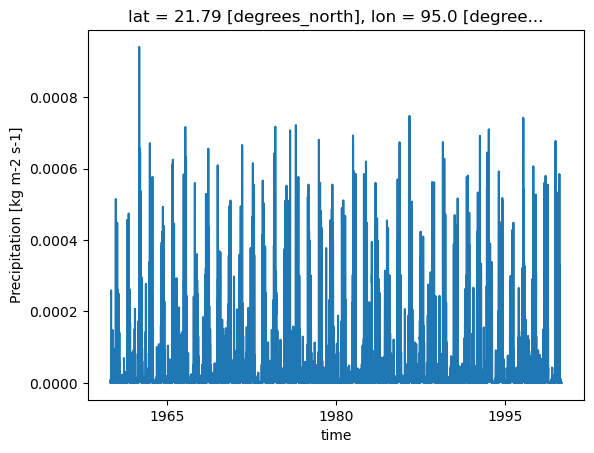

In [13]:
pr_noresm2_eas.isel(lat=0, lon=0).plot();

Awesome! In this section we learned:
- How to open a netCDF file using xarray.
- How to subset data using `.sel()` and `.isel()`.
- How to make simple plots using `.plot()`.

# Section 2: Computations and masks with xarray

From section 1, we see that when we display the xarray DataArray `pr_noresm2_eas`, the units for precipitations is $\text{kg m}^{-2}\,\text{s}^{-1}$
1 (mass flux). Let's convert that into a more oftenly used units of precipitation, $\text{mm day}^{-1}$. To do that, we need to multiply our values by 86400.

In [14]:
pr_noresm2_eas_mm_day = pr_noresm2_eas * 86400
pr_noresm2_eas_mm_day

<xarray.DataArray 'pr' (time: 14600, lat: 17, lon: 16)> Size: 16MB
array([[[3.7827617e-06, 2.3052899e-02, 3.6076346e-04, ...,
         1.4751718e-02, 1.8938165e-03, 2.2721465e-03],
        [1.2642978e-01, 1.5811090e-01, 2.0414175e-01, ...,
         3.9141679e-01, 3.9639492e-02, 4.7572780e-02],
        [3.2273293e-01, 9.7211915e-01, 1.8241581e+00, ...,
         2.9976210e-05, 1.0252084e-05, 1.9352596e-05],
        ...,
        [7.4095953e-01, 7.4541193e-01, 4.8956713e-01, ...,
         7.9097457e-02, 2.5718793e-01, 4.5302290e-01],
        [1.0124457e+00, 1.1210279e+00, 9.1755092e-01, ...,
         3.7248886e-01, 4.9980009e-01, 8.2001704e-01],
        [9.8742801e-01, 1.3005700e+00, 1.1513107e+00, ...,
         3.4819543e-01, 3.5564747e-01, 8.6711323e-01]],

       [[6.6084314e-05, 2.5857307e-05, 6.1076332e-04, ...,
         5.0234076e-02, 5.1526860e-03, 1.2706871e-02],
        [1.2856617e+00, 1.7678899e-01, 4.5639989e-01, ...,
         2.1294953e-01, 1.0280913e-02, 3.4112629e-01],
        [5.0556164e+00, 6.5346069e+00, 8.0910282e+00, ...,
         4.2147715e-02, 1.7915787e-03, 8.7324833e-04],
...
         2.7274983e-03, 1.4209938e-03, 2.8619004e-04],
        [2.0320339e-02, 4.3041229e-02, 8.9692408e-03, ...,
         1.4137307e-02, 3.8218438e-03, 5.6920177e-04],
        [1.2710780e-01, 3.7391376e-02, 4.6432763e-04, ...,
         2.6523376e-02, 2.1907140e-03, 2.8701967e-03]],

       [[1.6728605e-12, 1.9722361e-08, 8.0923155e-06, ...,
         2.1273911e+00, 4.0080976e+00, 4.7047257e+00],
        [2.5704647e-10, 6.2189401e-06, 7.5899297e-05, ...,
         2.2219761e-01, 2.2015922e-01, 1.0795192e-01],
        [2.4146787e-09, 1.4274615e-04, 4.8336899e-03, ...,
         1.4019060e+00, 4.4790700e-01, 3.8234100e-01],
        ...,
        [2.2526365e-04, 1.7449914e-02, 6.6519283e-02, ...,
         2.4362549e-03, 1.4391590e-03, 3.4169580e-03],
        [2.6395053e-02, 6.8606533e-02, 5.3863503e-02, ...,
         2.6046284e-02, 2.0821325e-02, 1.1782218e-02],
        [9.6596792e-02, 6.0502362e-02, 5.9472863e-02, ...,
         3.1258591e-02, 5.5311982e-02, 6.4347148e-02]]],
      shape=(14600, 17, 16), dtype=float32)
Coordinates:
  * time     (time) object 117kB 1960-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 136B 21.79 23.68 25.58 27.47 ... 48.32 50.21 52.11
  * lon      (lon) float64 128B 95.0 97.5 100.0 102.5 ... 127.5 130.0 132.5

Notice that after we've applied our conversion we don't have the attributes of `pr_noresm2_eas` anymore. This happens after every computation. In the case you needed to save the result of the computation to a netCDF file, it is best practice to indicate information about the data under attributes. You can do that by doing the following.

In [15]:
pr_noresm2_eas_mm_day.attrs["units"] = "mm day-1"

In [16]:
pr_noresm2_eas_mm_day

<xarray.DataArray 'pr' (time: 14600, lat: 17, lon: 16)> Size: 16MB
array([[[3.7827617e-06, 2.3052899e-02, 3.6076346e-04, ...,
         1.4751718e-02, 1.8938165e-03, 2.2721465e-03],
        [1.2642978e-01, 1.5811090e-01, 2.0414175e-01, ...,
         3.9141679e-01, 3.9639492e-02, 4.7572780e-02],
        [3.2273293e-01, 9.7211915e-01, 1.8241581e+00, ...,
         2.9976210e-05, 1.0252084e-05, 1.9352596e-05],
        ...,
        [7.4095953e-01, 7.4541193e-01, 4.8956713e-01, ...,
         7.9097457e-02, 2.5718793e-01, 4.5302290e-01],
        [1.0124457e+00, 1.1210279e+00, 9.1755092e-01, ...,
         3.7248886e-01, 4.9980009e-01, 8.2001704e-01],
        [9.8742801e-01, 1.3005700e+00, 1.1513107e+00, ...,
         3.4819543e-01, 3.5564747e-01, 8.6711323e-01]],

       [[6.6084314e-05, 2.5857307e-05, 6.1076332e-04, ...,
         5.0234076e-02, 5.1526860e-03, 1.2706871e-02],
        [1.2856617e+00, 1.7678899e-01, 4.5639989e-01, ...,
         2.1294953e-01, 1.0280913e-02, 3.4112629e-01],
        [5.0556164e+00, 6.5346069e+00, 8.0910282e+00, ...,
         4.2147715e-02, 1.7915787e-03, 8.7324833e-04],
...
         2.7274983e-03, 1.4209938e-03, 2.8619004e-04],
        [2.0320339e-02, 4.3041229e-02, 8.9692408e-03, ...,
         1.4137307e-02, 3.8218438e-03, 5.6920177e-04],
        [1.2710780e-01, 3.7391376e-02, 4.6432763e-04, ...,
         2.6523376e-02, 2.1907140e-03, 2.8701967e-03]],

       [[1.6728605e-12, 1.9722361e-08, 8.0923155e-06, ...,
         2.1273911e+00, 4.0080976e+00, 4.7047257e+00],
        [2.5704647e-10, 6.2189401e-06, 7.5899297e-05, ...,
         2.2219761e-01, 2.2015922e-01, 1.0795192e-01],
        [2.4146787e-09, 1.4274615e-04, 4.8336899e-03, ...,
         1.4019060e+00, 4.4790700e-01, 3.8234100e-01],
        ...,
        [2.2526365e-04, 1.7449914e-02, 6.6519283e-02, ...,
         2.4362549e-03, 1.4391590e-03, 3.4169580e-03],
        [2.6395053e-02, 6.8606533e-02, 5.3863503e-02, ...,
         2.6046284e-02, 2.0821325e-02, 1.1782218e-02],
        [9.6596792e-02, 6.0502362e-02, 5.9472863e-02, ...,
         3.1258591e-02, 5.5311982e-02, 6.4347148e-02]]],
      shape=(14600, 17, 16), dtype=float32)
Coordinates:
  * time     (time) object 117kB 1960-01-01 12:00:00 ... 1999-12-31 12:00:00
  * lat      (lat) float64 136B 21.79 23.68 25.58 27.47 ... 48.32 50.21 52.11
  * lon      (lon) float64 128B 95.0 97.5 100.0 102.5 ... 127.5 130.0 132.5
Attributes:
    units:    mm day-1

Now you've added the units of the data under attributes. For reference, units would be called the attribute "key" and mm day-1 would be called the attribute "value". You can provide other attributes as well if you wanted. You do not need to add attributes after doing every calculation as that will be time consuming but note that it will be useful whenever you want to save the data.

What if you wanted to know the average rate of precipitation across East Asia throughout the period that we have data for? We need to take the (1) spatial and (2) temporal average of `pr_noresm2_mm_day`.

To take the spatial mean, we need to take into account how a one-degree longitude spacing near the equator is ~111 km but would get closer to zero as we get nearer to the poles. Hence, we do a weighted spatial mean. To make things easier for us, we define a new function called `weighted_spatial_mean()` that takes into account our data and returns the latitudinally-weighted spatial mean.

In [17]:
def weighted_spatial_mean(data):
    # ref: https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html

    # assign weights depending on latitude
    weights = np.cos(np.deg2rad(data.lat))
    # give the weights a name
    weights.name = "weights"
    # let the data know about the weights
    data_weighted = data.weighted(weights)
    # take the weighted spatial mean
    data_weighted_mean = data_weighted.mean(("lon", "lat"))
    return data_weighted_mean

Let's now take the spatial and temporal average of `pr_noresm2_mm_day` to know how much rain East Asia gets per day (on average) throughout the period we have data for. We can print the results in a neat way using Python's f-string formatting. Note how we use `.values` and specified how many digits we want to display after the decimal point.

In [18]:
pr_noresm2_eas_mm_day_weighted_mean = weighted_spatial_mean(pr_noresm2_eas_mm_day).mean('time')
print(f"The average precipitation in East Asia is {pr_noresm2_eas_mm_day_weighted_mean.values:.2f} mm/day")

The average precipitation in East Asia is 2.94 mm/day


Let's take a look at the climatology of East Asian precipitation. We can do that by grouping all the days that correspond to a certain month ("split" into 12 groups, one for each month) and taking the means for each month ("apply" a monthly average calculation and "combine" the monthly averages into a single DataArray again).

In [19]:
# Take the weighted spatial mean first, group by month, and then take the monthly means
pr_noresm2_eas_mm_day_climatology = weighted_spatial_mean(pr_noresm2_eas_mm_day).groupby('time.month').mean()
pr_noresm2_eas_mm_day_climatology


<xarray.DataArray 'pr' (month: 12)> Size: 96B
array([0.89205213, 1.13082729, 1.90398391, 2.62691916, 3.62936639,
       5.33306772, 5.63756986, 5.39391777, 4.14922366, 2.39517409,
       1.21837629, 0.81420512])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

Now let's plot the climatology of East Asian precipitation!

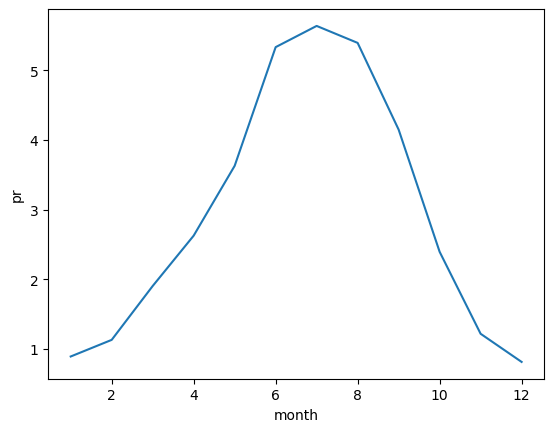

In [20]:
pr_noresm2_eas_mm_day_climatology.plot();

Now let's try masking our data. This means selectively processing our data based on a set of criteria. The default behavior of the function we use to do masking, `.where` is to make values that don't meet our criteria to be 'nan' which stands for 'not a number'. Here we mask `pr_noresm2_eas_mm_day` so that we get a new variable that only has values (numbers) of precipitation above 1 $\text{mm day}^{-1}$ and below 2 $\text{mm day}^{-1}$.

In [21]:
pr_noresm2_eas_mm_day_masked = pr_noresm2_eas_mm_day.where((pr_noresm2_eas_mm_day > 1) & (pr_noresm2_eas_mm_day < 2))

Now let's plot the first day of our masked data.

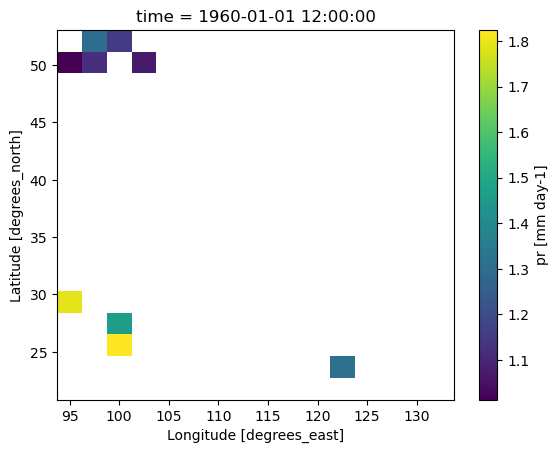

In [22]:
pr_noresm2_eas_mm_day_masked.isel(time=0).plot();

Remember that we can have different places that meet our criteria on different days within East Asia. Here's what the masked precipitation map looks like on the second day.

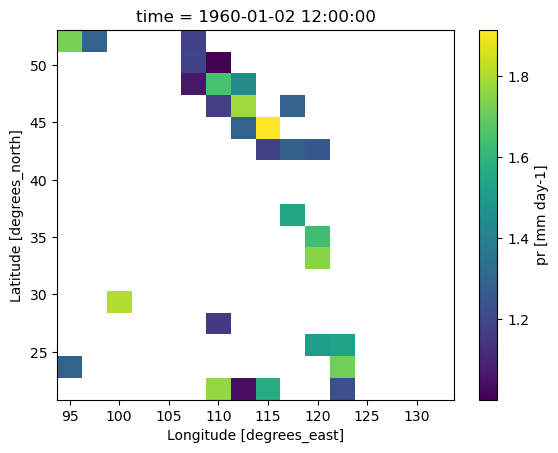

In [23]:
pr_noresm2_eas_mm_day_masked.isel(time=1).plot();

Awesome! In this section we learned:
- How to aggregate your data. In this example we learned how to take the `.mean()`, but we can also take the `.sum()`, `.median()`, `.min()`, and `.max()`.
- How to use `.groupby()` to "split", "apply", and "combine" our data. In this example we used it to get the climatology of East Asian precipitation.
- How to mask data using `.where()`.

# Practice

Let's practice making a prettier map using `pr_noresm2_mm_day`. The following code block provides a template of how we can produce maps of a dataset. You are welcome to play around and think about the different ways you can modify the map. A couple of suggestions:
- Try various map projections (ccrs.[Robinson](https://www.reddit.com/r/Maps/comments/1rxkhi/why_did_national_geographic_switch_from_robinson/), ccrs.[Mollweide](https://education.nationalgeographic.org/resource/selecting-map-projection/))
- Try various colormaps (cmap)
- Try various levels for the colorbar
- Try different days or aggregate data (for example: take the mean throughout whole period, [seasonally](https://docs.xarray.dev/en/stable/examples/monthly-means.html), etc.)

In [24]:
# Library for general plotting
import matplotlib.pyplot as plt

In [25]:
# Convert units to mm/day
pr_noresm2_mm_day = pr_noresm2 * 86400

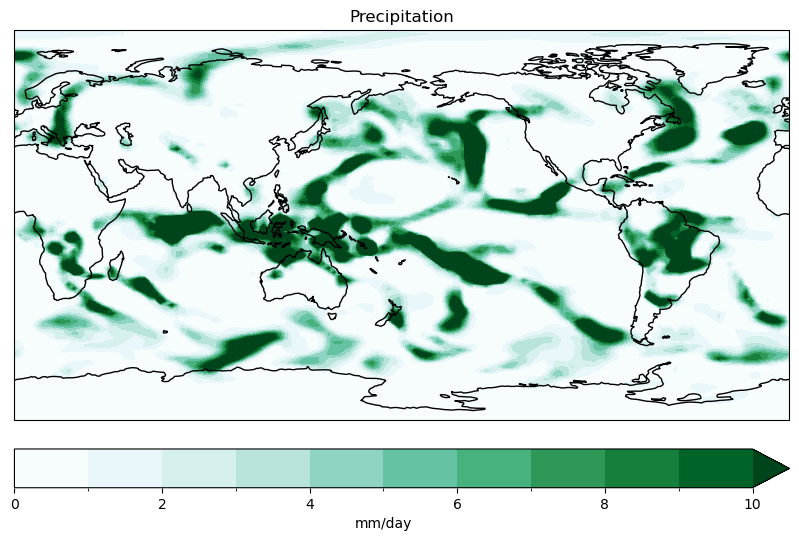

In [26]:
# Indicate data to visualize
data = pr_noresm2_mm_day.isel(time=0)

# Create map
fig = plt.figure(figsize=[10,7.5])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=180))
data.plot.contourf(ax=ax,
                   transform=ccrs.PlateCarree(),
                   levels=np.linspace(0,10,11),
                   cmap='BuGn',
                   cbar_kwargs={"label":'mm/day', "orientation": 'horizontal', "pad": 0.05})
ax.coastlines()

# Show figure
ax.set_title("Precipitation")
plt.show()

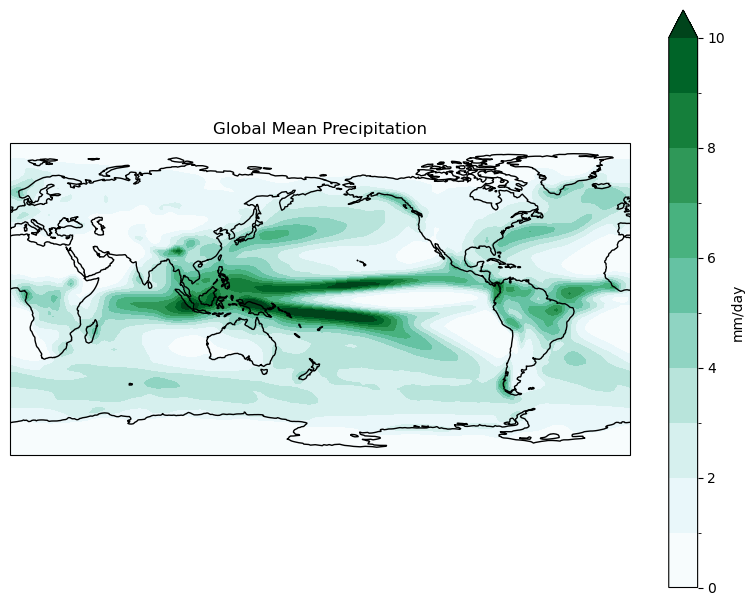

In [27]:
data = pr_noresm2_mm_day.mean('time')

# Create map
fig = plt.figure(figsize=[10,7.5])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=180))
data.plot.contourf(ax=ax,
                   transform=ccrs.PlateCarree(),
                   levels=np.linspace(0,10,11),
                   cmap='BuGn',
                   cbar_kwargs={"label":'mm/day', "orientation": 'vertical', "pad": 0.05})
ax.coastlines()

# Show figure
ax.set_title("Global Mean Precipitation")
plt.show()

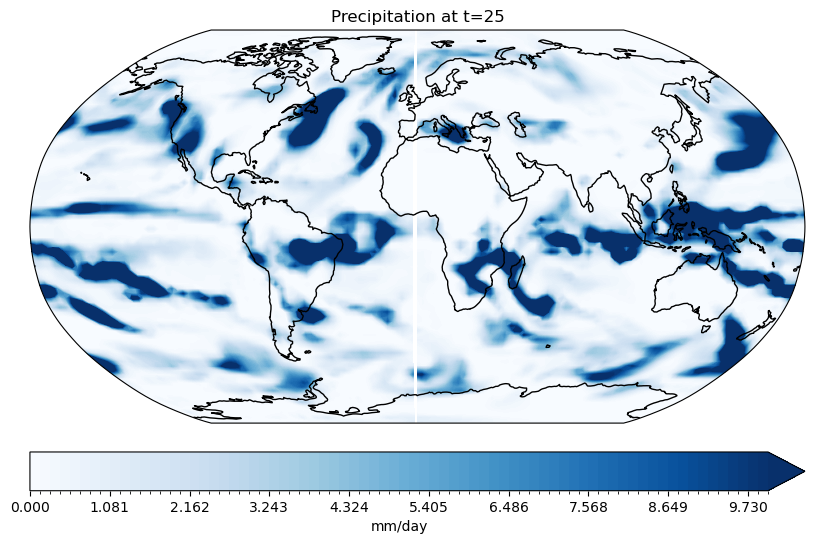

In [28]:
# Indicate data to visualize
data = pr_noresm2_mm_day.isel(time=25)

# Create map
fig = plt.figure(figsize=[10,7.5])
ax = fig.add_subplot(111,projection=ccrs.Robinson(central_longitude=0))
data.plot.contourf(ax=ax,
                   transform=ccrs.PlateCarree(),
                   levels=np.linspace(0,10,75),
                   cmap='Blues',
                   cbar_kwargs={"label":'mm/day', "orientation": 'horizontal', "pad": 0.05})
ax.coastlines()

# Show figure
ax.set_title("Precipitation at t=25")
plt.show()

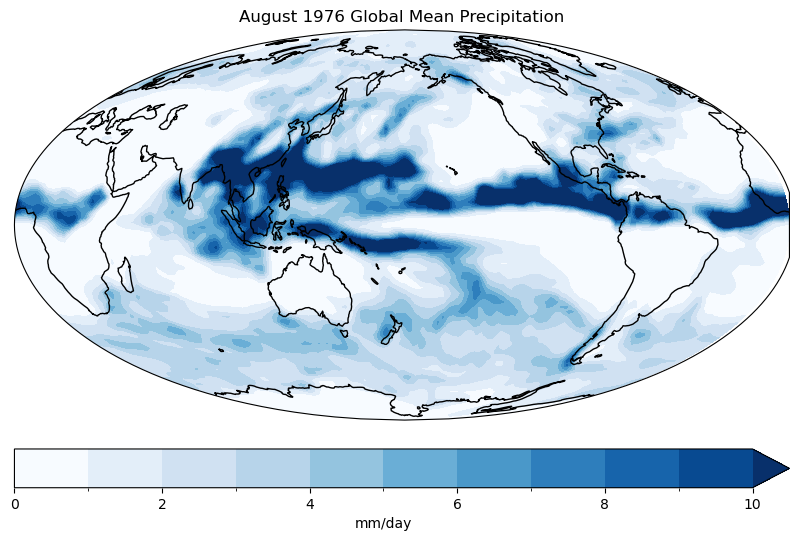

In [29]:
# Indicate data to visualize
data = pr_noresm2_mm_day.sel(time='1976-08').mean('time')

# Create map
fig = plt.figure(figsize=[10,7.5])
ax = fig.add_subplot(111,projection=ccrs.Mollweide(central_longitude=180))
data.plot.contourf(ax=ax,
                   transform=ccrs.PlateCarree(),
                   levels=np.linspace(0,10,11),
                   cmap='Blues',
                   cbar_kwargs={"label":'mm/day', "orientation": 'horizontal', "pad": 0.05})
ax.coastlines()

# Show figure
ax.set_title("August 1976 Global Mean Precipitation")
plt.show()

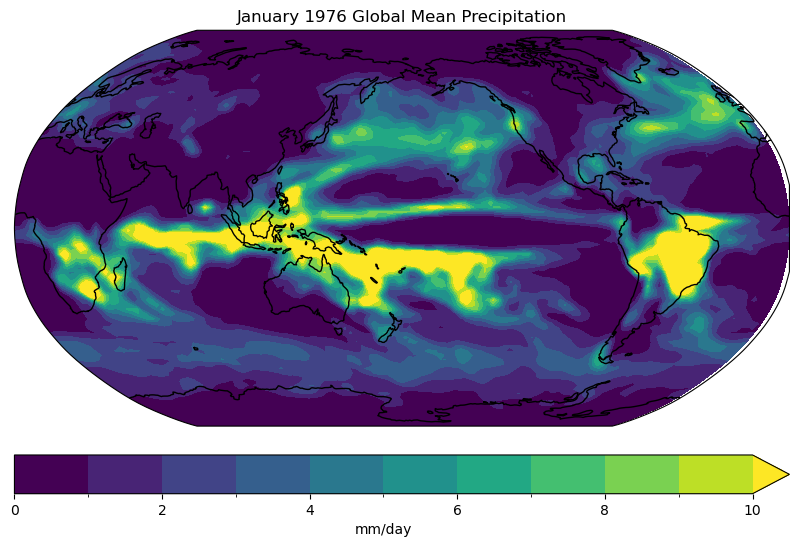

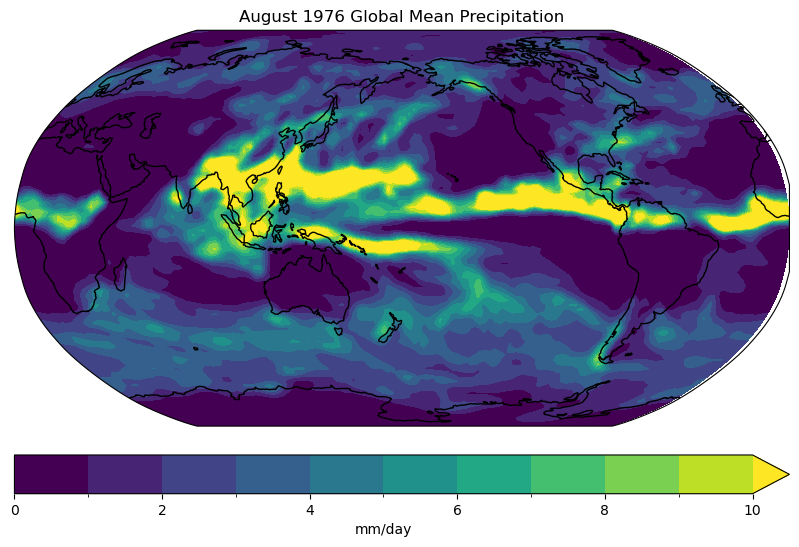

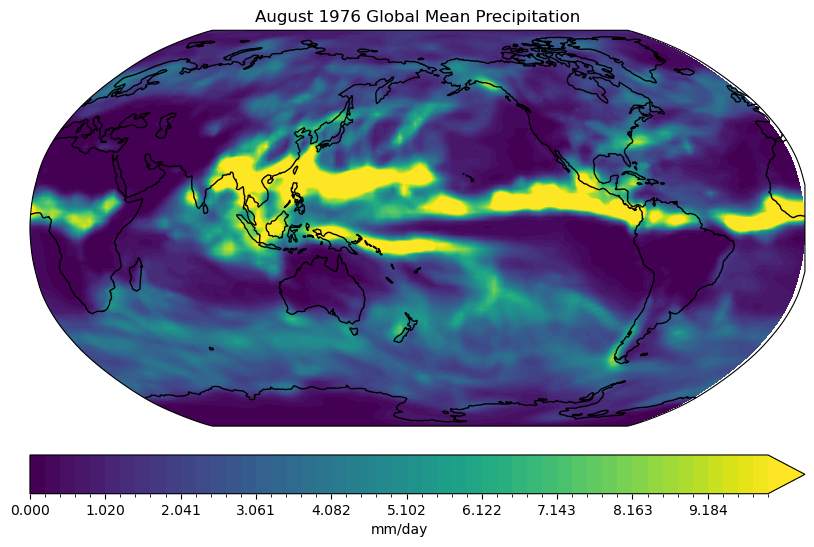

In [30]:
#average january 
data = pr_noresm2_mm_day.sel(time='1976-01').mean('time')


fig = plt.figure(figsize=[10,7.5])
ax = fig.add_subplot(111,projection=ccrs.Robinson(central_longitude=180))
data.plot.contourf(ax=ax,
                   transform=ccrs.PlateCarree(),
                   levels=np.linspace(0,10,11),
                   cmap='viridis',
                   cbar_kwargs={"label":'mm/day', "orientation": 'horizontal', "pad": 0.05})
ax.coastlines()


ax.set_title("January 1976 Global Mean Precipitation")
plt.show()

#average august
data = pr_noresm2_mm_day.sel(time='1976-08').mean('time')


fig = plt.figure(figsize=[10,7.5])
ax = fig.add_subplot(111,projection=ccrs.Robinson(central_longitude=180))
data.plot.contourf(ax=ax,
                   transform=ccrs.PlateCarree(),
                   levels=np.linspace(0,10,11),
                   cmap='viridis',
                   cbar_kwargs={"label":'mm/day', "orientation": 'horizontal', "pad": 0.05})
ax.coastlines()


ax.set_title("August 1976 Global Mean Precipitation")
plt.show()

# 50 steps

data = pr_noresm2_mm_day.sel(time='1976-08').mean('time')


fig = plt.figure(figsize=[10,7.5])
ax = fig.add_subplot(111,projection=ccrs.Robinson(central_longitude=180))
data.plot.contourf(ax=ax,
                   transform=ccrs.PlateCarree(),
                   levels=np.linspace(0,10,50),
                   cmap='viridis',
                   cbar_kwargs={"label":'mm/day', "orientation": 'horizontal', "pad": 0.05})
ax.coastlines()

ax.set_title("August 1976 Global Mean Precipitation")
plt.show()



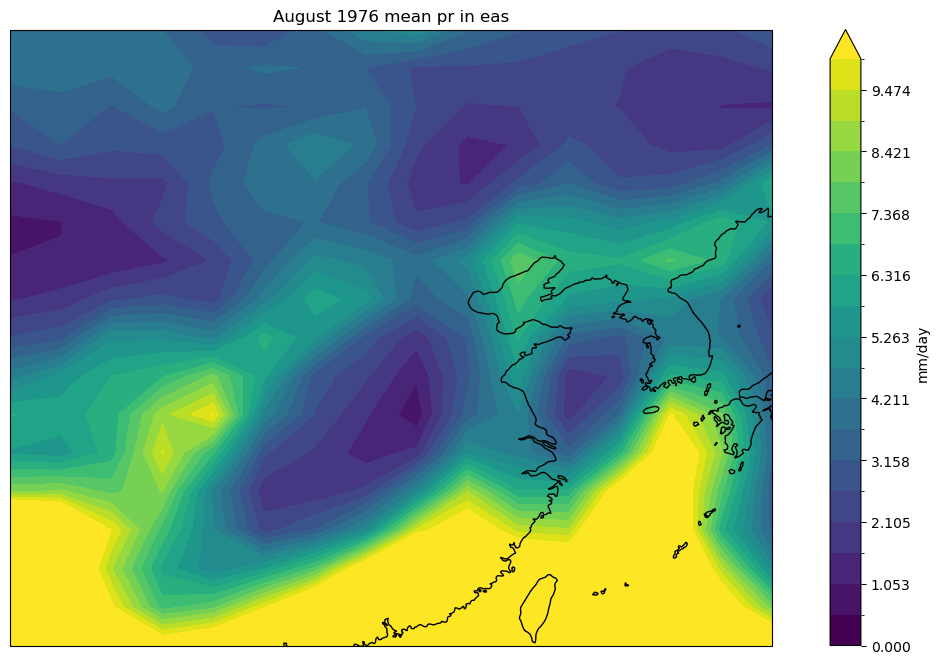

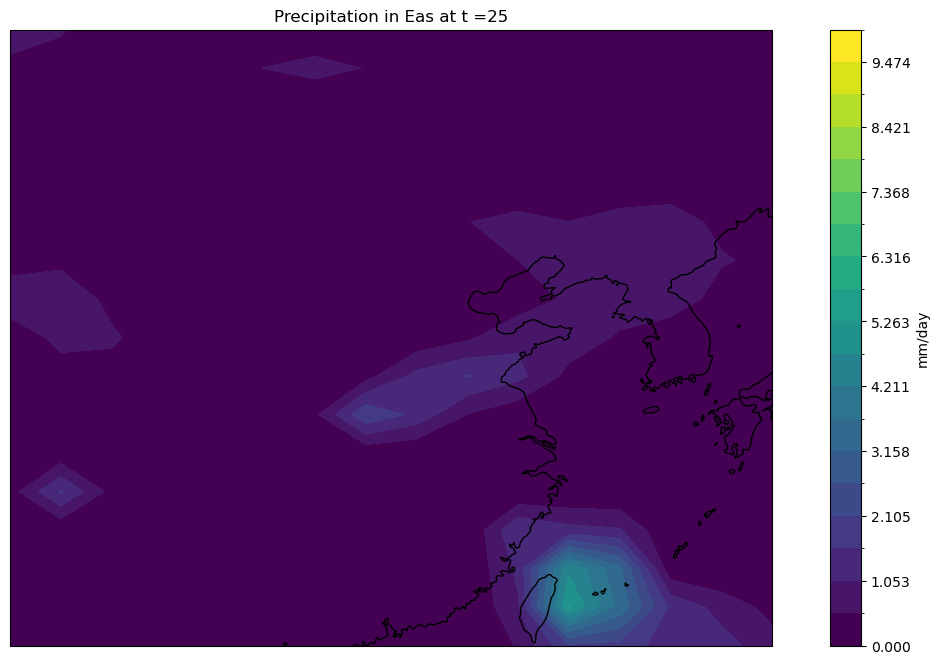

In [31]:
data = pr_noresm2_eas_mm_day.sel(time='1976-08').mean('time')

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
data.plot.contourf(ax=ax,
                   transform=ccrs.PlateCarree(),
                   levels=np.linspace(0,10,20),
                   cmap='viridis',
                   cbar_kwargs={"label":'mm/day',"orientation":'vertical', "pad":0.05})

ax.coastlines()

ax.set_title("August 1976 mean pr in eas")
plt.show()

data = pr_noresm2_eas_mm_day.isel(time=25)

fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
data.plot.contourf(ax=ax,
                   transform=ccrs.PlateCarree(),
                   levels=np.linspace(0,10,20),
                   cmap='viridis',
                   cbar_kwargs={"label":'mm/day',"orientation":'vertical', "pad":0.05})

ax.coastlines()

ax.set_title("Precipitation in Eas at t =25")
plt.show()